In [ ]:
!pip install requirements.txt

Restart the kernel. before proceeding further.

In [16]:
#IMPORTANT IMPORTS
lat = 18.518648
long = 73.815543
import torch
import mysql.connector
import pytorchvideo.data
import os
from transformers import VivitImageProcessor, VivitForVideoClassification
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from pytorchvideo.transforms import (
ApplyTransformToKey,
Normalize,
RandomShortSideScale,
RemoveKey,
ShortSideScale,
UniformTemporalSubsample,)
from torchvision.transforms import (
Compose,
Lambda,
RandomCrop,
RandomHorizontalFlip,
Resize,
)
from transformers import AutoTokenizer, AutoModelForVideoClassification
from transformers import pipeline

#Defining Model
model = AutoModelForVideoClassification.from_pretrained("prathameshdalal/vivit-b-16x2-kinetics400-UCF-Crime")
pipe = pipeline("video-classification", model="prathameshdalal/vivit-b-16x2-kinetics400-UCF-Crime")
image_processor = VivitImageProcessor.from_pretrained("google/vivit-b-16x2-kinetics400")

#Necessary Pre-processing Methods
mean = image_processor.image_mean
std = image_processor.image_std
if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
resize_to = (height, width)
num_frames_to_sample = model.config.num_frames
sample_rate = 4
fps = 30
clip_duration = num_frames_to_sample * sample_rate / fps

#transforms on dataset
val_transform = Compose(
    [
        ApplyTransformToKey(
            key="video",
            transform=Compose(
                [
                    UniformTemporalSubsample(num_frames_to_sample),
                    Lambda(lambda x: x / 255.0),
                    Normalize(mean, std),
                    Resize(resize_to),
                ]
            ),
        ),
    ]
)

test_dataset = pytorchvideo.data.Ucf101(
    data_path=os.path.join("T2"),
    clip_sampler=pytorchvideo.data.make_clip_sampler("uniform", clip_duration),
    decode_audio=False,
    transform=val_transform,
)

def run_inference(model, video):
    import torch.nn.functional as F
    # (num_frames, num_channels, height, width)
    permuted_sample_test_video = video.permute(1, 0, 2, 3)
    inputs = {
        "pixel_values": permuted_sample_test_video.unsqueeze(0)  # this can be skipped if you don't have labels available.
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    model = model.to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply softmax to get class probabilities
        probabilities = F.softmax(logits, dim=-1)

        # Get the class with the highest probability and its confidence score
        max_prob, predicted_class = torch.max(probabilities, 1)

    return max_prob.item(), predicted_class.item()


import imageio
import numpy as np
from IPython.display import Image

def unnormalize_img(img):
    """Un-normalizes the image pixels."""
    img = (img * std) + mean
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
    
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy())
        frames.append(frame_unnormalized)
    kargs = {"duration": 1}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename
def display_gif(video_tensor, gif_name="sample.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, gif_name)
    return Image(filename=gif_filename)


# -------------------------------------------------------------------------------------------------------------------------------------
#_------------------------------------------DO NOT CHANGE ANYTHING ABOVE THIS LINE -----------------------------------------------
#-------------------------------------------------------------------------------------------------------------------------------------


# Define the table name and columns

table_name = "crime_data"
columns = ["nature_of_crime", "risk_percentage", "latitude", "longitude"]  # Define your column names here
nature = 'Normal'
# Load or define your video data as sample_test_video["video"] before using it
count = 0
while(count<1):
    sample_test_video = next(iter(test_dataset))
    
    logits = run_inference(model, sample_test_video["video"])
    predicted_class_idx = logits[1]
    risk_level = logits[0]
    rl = int(round(risk_level * 100, 0))
    nature = model.config.id2label[predicted_class_idx]

    
    if nature != 'Normal':
        count = count + 1
        print(f"Predicted class: {nature}, risk level: {rl}")
    try:
        # Connect to YOUR LOCAL database:
    
        mydb = mysql.connector.connect(
            host="localhost",
            user="root",
            password="root",
            database="crime_detection"
        )

        mycursor = mydb.cursor()

        # Define the SQL query with placeholders
        if nature != 'Normal' and risk_level >= 0.25:
            sql = f"INSERT INTO {table_name} ({', '.join(columns)}) VALUES (%s, %s)"
            video_tensor = sample_test_video["video"]
            risk_level = risk_level * 100
            val = (nature, risk_level, lat, long)
            mycursor.execute(sql, val)
            mydb.commit()
    
    except mysql.connector.Error as error:
        print("Failed to insert record into MySQL table:", error)

    finally:
        try:
            if 'mycursor' in locals():
                # Close cursor
                mycursor.close()
            if 'mydb' in locals():
                # Release the database connection
                mydb.close()
        except mysql.connector.Error as error:
            print("Error closing resources:", error)


Predicted class: Fighting, risk level: 75
Failed to insert record into MySQL table: Not all parameters were used in the SQL statement


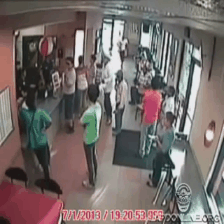

In [10]:
display_gif(video_tensor)